# Introduction

This is my personal project, looking at powerlifting data gathered and generously provided by [the OpenPowerlifting project](https://www.openpowerlifting.org). (You may download a copy of the data [here](https://gitlab.com/openpowerlifting/opl-data)). As somebody who has been lifting as a serious hobby for a couple years now, I've entertained the notion of competing in an official powerlifting meet once or twice. What better way to see how competitive I am now (and how much better I would need to get to be truly competitive) than examining data collected from real lifters?

In this analysis, I hope to gain some insight into the trends in powerlifting competitions, the ability level of competing powerlifters and how I personally would stack up against the competition.

## Step 1: Importing the relevant Python packages and the dataset

In [1]:
# Importing useful packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Importing my dataset.
raw = pd.read_csv('./Input/openpowerlifting-2020-10-16.csv', parse_dates=['Date'])

In [3]:
# Quick scan of a data summary.
raw.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2116021 entries, 0 to 2116020
Data columns (total 40 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Name              2116021 non-null  object        
 1   Sex               2116021 non-null  object        
 2   Event             2116021 non-null  object        
 3   Equipment         2116021 non-null  object        
 4   Age               1229557 non-null  float64       
 5   AgeClass          1437418 non-null  object        
 6   BirthYearClass    1284735 non-null  object        
 7   Division          2113327 non-null  object        
 8   BodyweightKg      2087100 non-null  float64       
 9   WeightClassKg     2091540 non-null  object        
 10  Squat1Kg          512375 non-null   float64       
 11  Squat2Kg          506261 non-null   float64       
 12  Squat3Kg          491158 non-null   float64       
 13  Squat4Kg          5532 non-null     float6

## Step 2: Initial Data Pruning

I love that there is so much data on powerlifters out there! However, I'll only need a subset of the 2 million (and counting) records this time. First, I'll narrow down the data for only results that are:

* In Oklahoma,
* Tested,
* A full powerlifting meet (with all three of squat, bench, and deadlift).

I'll probably notice other low hanging fruit I can quickly take a look at pruning and validating after that.

In [4]:
# Looking at country and state in an attempt to narrow the data way down.
raw[raw.MeetCountry == 'USA'].MeetState.value_counts().head(15)

TX    525393
CA     72277
PA     45478
FL     42871
OH     37690
NV     37576
IL     27046
NY     26930
NJ     21240
MI     19978
VA     19525
GA     18707
WA     14680
OK     14637
WI     14199
Name: MeetState, dtype: int64

In [5]:
# Creating a subset of the data, based on relevant filters.
ok = raw.loc[(raw.MeetCountry == 'USA') & (raw.MeetState == 'OK') & (raw.Event == 'SBD') & (raw.Tested == 'Yes')].reset_index(drop=True)

In [6]:
# Another quick peek at a data summary.
ok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4735 entries, 0 to 4734
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name              4735 non-null   object        
 1   Sex               4735 non-null   object        
 2   Event             4735 non-null   object        
 3   Equipment         4735 non-null   object        
 4   Age               1559 non-null   float64       
 5   AgeClass          2346 non-null   object        
 6   BirthYearClass    1996 non-null   object        
 7   Division          4735 non-null   object        
 8   BodyweightKg      4613 non-null   float64       
 9   WeightClassKg     4731 non-null   object        
 10  Squat1Kg          398 non-null    float64       
 11  Squat2Kg          395 non-null    float64       
 12  Squat3Kg          384 non-null    float64       
 13  Squat4Kg          63 non-null     float64       
 14  Best3SquatKg      4610 n

After consulting the accompanying README to confirm what some of the columns are, we can safely prune a *lot* of attributes. This should help make any EDA more manageable.

Some are just redundant now (like `Tested`) after the initial pruning, many are not of interest currently (like `Federation`), and some just have too many nulls to be valuable (like `Squat1Kg`).

In [7]:
# Dropping columns that are either redundant, of no interest currently or possibly valuable but with too many nulls.
ok = ok.drop(columns=['Event', 'Country', 'Tested', 'Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Squat4Kg', 'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Bench4Kg', 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Deadlift4Kg', 'MeetCountry', 'MeetState', 'ParentFederation'])

In [8]:
# Another look at a summary of null counts and data types to see where else I can narrow down the data.
ok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4735 entries, 0 to 4734
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name             4735 non-null   object        
 1   Sex              4735 non-null   object        
 2   Equipment        4735 non-null   object        
 3   Age              1559 non-null   float64       
 4   AgeClass         2346 non-null   object        
 5   BirthYearClass   1996 non-null   object        
 6   Division         4735 non-null   object        
 7   BodyweightKg     4613 non-null   float64       
 8   WeightClassKg    4731 non-null   object        
 9   Best3SquatKg     4610 non-null   float64       
 10  Best3BenchKg     4567 non-null   float64       
 11  Best3DeadliftKg  4501 non-null   float64       
 12  TotalKg          4463 non-null   float64       
 13  Place            4735 non-null   object        
 14  Dots             4344 non-null   float64

After taking a look at null counts and data types, `Division`, `Place`, `MeetTown`, `Federation`, and `WeightClassKg` look like a few good attributes to scan for various reasons.

*Spoilers:*
- *Keeping `Division` based on variety of values.*
- *`Place` was non-numeric because of DQ's; they were replaced with 0.*
- *`MeetTown` and `Federation` look mostly uninteresting, but we'll keep them for now.*
- *`MeetYear` attribute was created from `Date` column.*
- *`WeightClassKg` was non-numeric because of the "+" for [unlimited](https://www.livestrong.com/article/471565-the-weight-requirements-for-powerlifting/) weight classes; those records were dropped.*

In [9]:
# Looking at values in Division.
ok.Division.value_counts()

Pure             340
Pure Novice      237
Natural          231
pure             220
jr               203
                ... 
retrowjr           1
F-O                1
Masters 60-64      1
Grand Masters      1
M-M1b              1
Name: Division, Length: 154, dtype: int64

In [10]:
# Looking at values in Place to see why it's an object column.
ok.Place.value_counts()

1     2698
2      739
3      359
DQ     272
4      196
5      125
6       85
7       65
8       50
9       43
10      33
11      20
12      15
13      11
14       7
15       6
16       4
17       3
18       1
21       1
20       1
19       1
Name: Place, dtype: int64

In [11]:
# Replacing all non-numeric, "invalid" places with a 0.
ok.loc[ok.Place == 'DQ', 'Place'] = 0

In [12]:
# Checking to make sure value replacement was done correctly.
ok.Place.value_counts()

1     2698
2      739
3      359
0      272
4      196
5      125
6       85
7       65
8       50
9       43
10      33
11      20
12      15
13      11
14       7
15       6
16       4
17       3
20       1
18       1
19       1
21       1
Name: Place, dtype: int64

In [13]:
# Converting Place to an integer since all non-numeric values have been replaced with integers.
ok.Place = ok.Place.astype(int)

In [14]:
# Looking at MeetTown to see if it can be dropped.
ok.MeetTown.value_counts(dropna=False)

Oklahoma City    3851
NaN               671
Tulsa             127
Henryetta          44
Ardmore            32
Stillwater         10
Name: MeetTown, dtype: int64

In [15]:
ok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4735 entries, 0 to 4734
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name             4735 non-null   object        
 1   Sex              4735 non-null   object        
 2   Equipment        4735 non-null   object        
 3   Age              1559 non-null   float64       
 4   AgeClass         2346 non-null   object        
 5   BirthYearClass   1996 non-null   object        
 6   Division         4735 non-null   object        
 7   BodyweightKg     4613 non-null   float64       
 8   WeightClassKg    4731 non-null   object        
 9   Best3SquatKg     4610 non-null   float64       
 10  Best3BenchKg     4567 non-null   float64       
 11  Best3DeadliftKg  4501 non-null   float64       
 12  TotalKg          4463 non-null   float64       
 13  Place            4735 non-null   int32         
 14  Dots             4344 non-null   float64

In [16]:
# Looking at Federation to see if any data manipulation would be helpful.
ok.Federation.value_counts()

NASA     4283
USAPL     189
AAU       166
USPA       76
ADFPA      21
Name: Federation, dtype: int64

In [17]:
# Checking to see why WeightClassKg was an object column.
ok.WeightClassKg.value_counts()

82.5     506
90       504
100      463
75       391
110      334
125      286
67.5     282
60       203
93       181
103      147
56       137
113.5    130
85       126
70       105
77.5      97
52        91
127       79
125+      77
140       76
90+       68
140+      65
63        50
143+      46
143       41
58        35
54        32
48        26
105       17
40        16
83        14
44        12
50        12
66        10
62.5       8
77         8
72         7
84         6
74         6
46         6
57.5       5
120        5
84+        5
85+        4
53         2
120+       2
35         2
57         2
145        1
59         1
145+       1
110+       1
Name: WeightClassKg, dtype: int64

In [18]:
# Dropping records in the super heavyweight weight classes since they will not be relevant to me.
ok = ok.loc[~ok['WeightClassKg'].str.contains('\+', na=True)].reset_index(drop=True)

#Checking WeightClassKg again to see if row dropping was done correctly.
ok.WeightClassKg.value_counts()

82.5     506
90       504
100      463
75       391
110      334
125      286
67.5     282
60       203
93       181
103      147
56       137
113.5    130
85       126
70       105
77.5      97
52        91
127       79
140       76
63        50
143       41
58        35
54        32
48        26
105       17
40        16
83        14
50        12
44        12
66        10
77         8
62.5       8
72         7
46         6
84         6
74         6
57.5       5
120        5
57         2
35         2
53         2
59         1
145        1
Name: WeightClassKg, dtype: int64

In [19]:
# Converting WeightClassKg to a float, now that all non-numeric values have been dropped.
ok.WeightClassKg = ok.WeightClassKg.astype(float)
ok.WeightClassKg.dtype

dtype('float64')

In [20]:
# Looking at a numerical summary for anomalies and interesting quirks.
ok.describe()

,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift
count,1435.000000,4462.000000,4462.000000,4343.000000,4298.000000,4239.000000,4201.000000,4462.000000,4201.000000,4201.000000,4201.000000,4187.000000
mean,33.356098,86.900081,88.623487,191.404536,122.505977,205.984102,526.637910,2.063873,365.125301,363.462257,345.185080,65.597509
std,12.372404,21.241220,21.838921,77.122816,54.440243,60.810461,165.715593,2.297762,75.633393,75.072247,74.089818,13.197698
min,0.500000,25.720000,35.000000,-427.500000,-260.000000,-242.500000,85.000000,0.000000,106.470000,110.230000,109.150000,18.300000
25%,24.000000,71.782500,75.000000,140.000000,90.000000,165.000000,397.500000,1.000000,315.220000,314.200000,296.270000,57.270000
50%,32.000000,85.525000,90.000000,200.000000,130.000000,215.000000,547.500000,1.000000,372.680000,371.880000,354.180000,66.630000
75%,40.000000,100.000000,102.250000,245.000000,160.000000,250.000000,652.500000,2.000000,420.620000,418.450000,399.500000,74.890000
max,76.500000,145.000000,145.000000,410.000000,300.000000,350.000000,1000.000000,21.000000,565.490000,575.580000,564.590000,106.250000


We have negative weights lifted! Looking at the README again, it looks like failed attempts were denoted with negatives. We can safely drop those records since I'm mostly interested in "successful" meets. This should also take care of the nulls in `TotalKg` because it looks like this might be empty only if the lifter was disqualified; not recording a successful attempt on any of the three lifts is one way to get disqualified.

*\[Editor's Note: Putting successful in quotes because not completing at least one attempt in each of the three lifts doesn't necessarily mean the meet was unsuccessful to the lifter personally.\]*

In [21]:
# Dropping all negative best lifts and re-inspecting the numerical summaries.
ok = ok.loc[(ok.Best3SquatKg > 0) & (ok.Best3BenchKg > 0) & (ok.Best3DeadliftKg > 0)].reset_index(drop=True)
# Making sure all the negatives are removed.
ok.describe()

,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift
count,1358.000000,4191.000000,4191.000000,4191.000000,4191.000000,4191.000000,4191.000000,4191.000000,4191.000000,4191.000000,4191.000000,4177.000000
mean,33.318115,86.731854,88.466714,194.278530,125.471413,206.662279,526.412059,2.194942,364.980308,363.316080,345.031427,65.552188
std,12.412452,21.401947,21.997785,67.926792,46.117247,58.203569,165.729032,2.309973,75.635887,75.077045,74.090519,13.167651
min,0.500000,25.720000,35.000000,25.000000,15.000000,25.000000,85.000000,1.000000,106.470000,110.230000,109.150000,18.300000
25%,23.500000,70.975000,75.000000,141.250000,92.500000,165.000000,396.000000,1.000000,314.955000,314.185000,296.055000,57.250000
50%,32.000000,85.000000,90.000000,200.000000,130.000000,215.000000,547.500000,1.000000,372.620000,371.800000,353.970000,66.630000
75%,40.000000,100.000000,103.000000,245.000000,160.000000,250.000000,652.500000,2.000000,420.520000,418.150000,399.320000,74.850000
max,76.500000,145.000000,145.000000,410.000000,300.000000,350.000000,1000.000000,21.000000,565.490000,575.580000,564.590000,106.250000


Finally, there is one more low hanging fruit to pluck: duplicate records.

In [22]:
# Checking for duplicate records
ok.loc[ok.duplicated(keep=False)]

,Name,Sex,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,Best3SquatKg,...,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Federation,Date,MeetTown,MeetName
2014,Steve Anderson,M,Single-ply,18.0,18-19,NaN,teen,60.06,63.0,172.5,...,455.0,1,383.72,387.70,378.58,65.34,NASA,1997-08-16,Oklahoma City,World Cup
2017,Daniel Lucente,M,Single-ply,19.0,18-19,19-23,teen,83.37,85.0,227.5,...,597.5,1,402.36,397.79,382.56,68.82,NASA,1997-08-16,Oklahoma City,World Cup
2084,Steve Anderson,M,Single-ply,18.0,18-19,NaN,teen,60.06,63.0,172.5,...,455.0,1,383.72,387.70,378.58,65.34,NASA,1997-08-16,Oklahoma City,World Cup
2085,Daniel Lucente,M,Single-ply,19.0,18-19,19-23,teen,83.37,85.0,227.5,...,597.5,1,402.36,397.79,382.56,68.82,NASA,1997-08-16,Oklahoma City,World Cup
2984,Tammy Roland,F,Single-ply,16.0,16-17,14-18,wteen,69.04,70.0,100.0,...,265.0,1,270.08,266.18,234.70,45.54,NASA,1997-02-07,Oklahoma City,Natural Nationals
2996,Tammy Roland,F,Single-ply,16.0,16-17,14-18,wteen,69.04,70.0,100.0,...,265.0,1,270.08,266.18,234.70,45.54,NASA,1997-02-07,Oklahoma City,Natural Nationals
3958,Chad Frazier,M,Single-ply,19.0,18-19,19-23,teen,76.34,77.5,160.0,...,470.0,2,333.44,330.85,319.44,57.10,NASA,1998-08-08,Oklahoma City,World Cup
4036,Chad Frazier,M,Single-ply,19.0,18-19,19-23,teen,76.34,77.5,160.0,...,470.0,2,333.44,330.85,319.44,57.10,NASA,1998-08-08,Oklahoma City,World Cup
4042,Mary Villegas,F,Single-ply,17.0,16-17,14-18,wteen,51.62,54.0,110.0,...,297.5,1,364.48,372.98,330.71,60.90,NASA,1998-08-08,Oklahoma City,World Cup
4048,Mary Villegas,F,Single-ply,17.0,16-17,14-18,wteen,51.62,54.0,110.0,...,297.5,1,364.48,372.98,330.71,60.90,NASA,1998-08-08,Oklahoma City,World Cup


It looks like we have 5 duplicates left. We'll simply drop all except the first of each duplicate record.

In [23]:
# Dropping duplicates and checking we only dropped 5 records.
print('Before:', len(ok))
ok = ok.loc[~ok.duplicated()].reset_index(drop=True)
print('After:', len(ok))

Before: 4191
After: 4186


In [24]:
ok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4186 entries, 0 to 4185
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name             4186 non-null   object        
 1   Sex              4186 non-null   object        
 2   Equipment        4186 non-null   object        
 3   Age              1353 non-null   float64       
 4   AgeClass         2058 non-null   object        
 5   BirthYearClass   1736 non-null   object        
 6   Division         4186 non-null   object        
 7   BodyweightKg     4186 non-null   float64       
 8   WeightClassKg    4186 non-null   float64       
 9   Best3SquatKg     4186 non-null   float64       
 10  Best3BenchKg     4186 non-null   float64       
 11  Best3DeadliftKg  4186 non-null   float64       
 12  TotalKg          4186 non-null   float64       
 13  Place            4186 non-null   int32         
 14  Dots             4186 non-null   float64

It looks like we've managed to remove virtually all the nulls from our data. (More accurately, we've more or less removed all the records with nulls, but I digress.) We still have a noticeable amount in `MeetTown` but that may not end up being used anyway.

### Warning: A Few Details on Powerlifting Meets and Scoring

For those who are unfamiliar, Dots, Wilks, Glossbreener, and Goodlift are all different ways powerlifting is scored, to try to standardize performance and make performance comparable across different bodyweights. One powerlifting meet will typically have different weight classes all competing in the same event. Lifters compete first within their own weight class, but with the help of these scoring methods, an overall best lifter is often awarded too.

After a [bit of](https://barbend.com/best-wilks-scores/) [research](https://wilkscalculator.com/a/what-is-a-good-wilks-score), it looks like the `Dots`, `Wilks`, `Glossbrenner` and `Goodlift` scores all fall in the reasonable range. However, I want to take a closer look because the max scores seem to be very close to the upper limit of recorded human powerlifting performance to date. (For example, the best raw, tested Wilks of all time is right around 600!) Maybe we have data anomalies... or maybe I get to learn about some of the world's best powerlifters who have competed right here in my city. Who knows! Fingers crossed for the latter.

## Step 3: Feature Engineering and Imputation

The two things that came to mind after the previous step of data pruning was a year column from `Date` and inspecting the 14 nulls in `Goodlift` to see if we could impute the values, given that it should be a simple calculation from the existing data we have.

Googling through the [existing literature](https://www.powerlifting.sport/fileadmin/ipf/data/ipf-formula/IPF_GL_Coefficients-2020.pdf) on the scoring system, I was able to find the exact formula to derive the multiplier, based on sex, equipment and bodyweight. All of this is readily avaiable in our dataset.

In [25]:
# Creating a new column, with just the year of the meet.
ok['MeetYear'] = ok.Date.dt.year

In [26]:
# Initializing IPF GL points coefficients to calculate any competitor's missing IPF GL points.
equipped_M = [1236.25115, 1449.21864, 0.01644]
raw_M = [1199.72839, 1025.18162, 0.00921]
equipped_F = [758.63878, 949.31382, 0.02435]
raw_F = [610.32796, 1045.59282, 0.03048]

In [27]:
# Checking all lifters with missing IPF GL points.
display(ok.loc[ok.Goodlift.isnull(), ['MeetYear', 'Sex', 'Equipment', 'BodyweightKg', 'TotalKg', 'Goodlift']])

# Getting the indices of all the blanks to double check afterwards.
GL_check = ok.loc[ok.Goodlift.isnull(), ['MeetYear', 'Sex', 'Equipment', 'BodyweightKg', 'TotalKg', 'Goodlift']].index

,MeetYear,Sex,Equipment,BodyweightKg,TotalKg,Goodlift
1888,2016,F,Wraps,33.61,95.5,NaN
1944,2017,M,Wraps,34.75,162.5,NaN
2176,2011,F,Wraps,26.67,147.0,NaN
2177,2011,F,Wraps,31.21,157.5,NaN
2669,1998,M,Single-ply,34.56,120.0,NaN
2759,2005,M,Single-ply,31.30,107.5,NaN
2856,2013,F,Wraps,32.84,182.0,NaN
2921,2013,F,Wraps,29.94,168.5,NaN
2979,1997,M,Single-ply,33.84,132.5,NaN
3524,2012,F,Wraps,27.67,164.5,NaN


In [28]:
# Replacing all the Goodlift values with the correct values, based on the right coefficients, depending on the lifter's attributes.
for i in range(len(ok)):
    if np.isnan(ok.iloc[i].Goodlift):
        if ok.iloc[i].Sex == 'F':
            if ok.iloc[i].Equipment == 'Single-ply':
                ok.at[i,'Goodlift'] = round(100/(equipped_F[0]-equipped_F[1]*np.exp(-equipped_F[2]*ok.iloc[i].BodyweightKg))*ok.iloc[i].TotalKg,2)
            # Raw and Wraps use the same coefficients.
            else:
                ok.at[i,'Goodlift'] = round(100/(raw_F[0]-raw_F[1]*np.exp(-raw_F[2]*ok.iloc[i].BodyweightKg))*ok.iloc[i].TotalKg,2)
        elif ok.iloc[i].Sex == 'M':
            if ok.iloc[i].Equipment == 'Single-ply':
                ok.at[i,'Goodlift'] = round(100/(equipped_M[0]-equipped_M[1]*np.exp(-equipped_M[2]*ok.iloc[i].BodyweightKg))*ok.iloc[i].TotalKg,2)
            # Raw and Wraps use the same coefficients.
            else:
                ok.at[i,'Goodlift'] = round(100/(raw_M[0]-raw_M[1]*np.exp(-raw_M[2]*ok.iloc[i].BodyweightKg))*ok.iloc[i].TotalKg,2)

In [29]:
# Double checking that the coefficients are correctly replaced.
ok.iloc[GL_check][['MeetYear', 'Sex', 'Equipment', 'BodyweightKg', 'TotalKg', 'Goodlift']]

,MeetYear,Sex,Equipment,BodyweightKg,TotalKg,Goodlift
1888,2016,F,Wraps,33.61,95.5,40.65
1944,2017,M,Wraps,34.75,162.5,35.69
2176,2011,F,Wraps,26.67,147.0,100.32
2177,2011,F,Wraps,31.21,157.5,76.28
2669,1998,M,Single-ply,34.56,120.0,28.90
2759,2005,M,Single-ply,31.30,107.5,29.06
2856,2013,F,Wraps,32.84,182.0,80.51
2921,2013,F,Wraps,29.94,168.5,88.44
2979,1997,M,Single-ply,33.84,132.5,32.68
3524,2012,F,Wraps,27.67,164.5,102.52


In [30]:
ok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4186 entries, 0 to 4185
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name             4186 non-null   object        
 1   Sex              4186 non-null   object        
 2   Equipment        4186 non-null   object        
 3   Age              1353 non-null   float64       
 4   AgeClass         2058 non-null   object        
 5   BirthYearClass   1736 non-null   object        
 6   Division         4186 non-null   object        
 7   BodyweightKg     4186 non-null   float64       
 8   WeightClassKg    4186 non-null   float64       
 9   Best3SquatKg     4186 non-null   float64       
 10  Best3BenchKg     4186 non-null   float64       
 11  Best3DeadliftKg  4186 non-null   float64       
 12  TotalKg          4186 non-null   float64       
 13  Place            4186 non-null   int32         
 14  Dots             4186 non-null   float64

In [31]:
ok.describe()

,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,MeetYear
count,1353.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000
mean,33.375462,86.754126,88.488892,194.326641,125.514976,206.701292,526.542747,2.196130,364.997226,363.330671,345.050339,65.565741,2002.998328
std,12.399187,21.401454,21.998369,67.934384,46.107642,58.211939,165.731329,2.311055,75.662503,75.102210,74.109671,13.247908,9.359015
min,0.500000,25.720000,35.000000,25.000000,15.000000,25.000000,85.000000,1.000000,106.470000,110.230000,109.150000,18.300000,1991.000000
25%,24.000000,71.042500,75.000000,142.500000,92.500000,165.000000,396.375000,1.000000,314.877500,314.182500,296.052500,57.250000,1995.000000
50%,32.500000,85.000000,90.000000,200.000000,130.000000,215.000000,547.500000,1.000000,372.620000,371.800000,353.980000,66.630000,2002.000000
75%,40.000000,100.000000,103.000000,245.000000,160.000000,250.000000,652.500000,2.000000,420.530000,418.337500,399.422500,74.890000,2012.000000
max,76.500000,145.000000,145.000000,410.000000,300.000000,350.000000,1000.000000,21.000000,565.490000,575.580000,564.590000,111.020000,2020.000000


## Step 4: (Continued) Data Validation

I think the data is shaping up nicely! More out of curiosity than anything, I wanted to take a look at some of the scoring, in particular Wilks and Goodlift/IPF GL points. As I previously mentioned, we have some records of apparently super elite powerlifters competing in Oklahoma. This is my chance to learn a bit more about the sport and some of the best to ever compete... or find some data that needs to be corrected.

(Fingers crossed for the former.)

In [32]:
ok.Wilks.value_counts().sort_index(ascending=False).head()

575.58    2
561.29    1
552.56    1
547.65    1
547.61    1
Name: Wilks, dtype: int64

In [33]:
display(ok.loc[ok.Wilks.isin(ok.Wilks.value_counts().sort_index(ascending=False).head().index)].sort_values('Wilks', ascending=False))
ok.loc[ok.Wilks.isin(ok.Wilks.value_counts().sort_index(ascending=False).head().index), 'Name'].unique()

,Name,Sex,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,Best3SquatKg,...,Place,Dots,Wilks,Glossbrenner,Goodlift,Federation,Date,MeetTown,MeetName,MeetYear
2680,Mike Ewoldsen,M,Single-ply,40.0,40-44,40-49,m1,55.57,56.0,230.0,...,1,565.49,575.58,564.59,95.80,NASA,2005-02-12,Oklahoma City,Natural Nationals,2005
2727,Mike Ewoldsen,M,Single-ply,40.0,40-44,40-49,pure,55.57,56.0,230.0,...,1,565.49,575.58,564.59,95.80,NASA,2005-02-12,Oklahoma City,Natural Nationals,2005
3754,Henry Thomason,M,Single-ply,30.0,24-34,24-39,open,136.03,140.0,410.0,...,1,552.52,561.29,534.58,92.47,NASA,2009-10-17,Oklahoma City,Unequipped Nationals,2009
3519,Teale Adelmann,F,Single-ply,NaN,NaN,NaN,wm1,55.07,56.0,142.5,...,1,543.28,552.56,488.94,90.83,NASA,2012-08-11,Oklahoma City,World Cup,2012
1001,Curtis Payne,M,Single-ply,28.0,24-34,24-39,Pure,82.50,82.5,320.0,...,1,553.77,547.65,526.95,94.74,NASA,1992-03-05,Oklahoma City,Natural Nationals,1992
3587,Rich Kahle,M,Single-ply,NaN,24-34,24-39,sm1,124.38,125.0,365.0,...,1,544.94,547.61,524.25,91.54,NASA,2008-08-02,Oklahoma City,World Cup,2008


array(['Curtis Payne', 'Mike Ewoldsen', 'Teale Adelmann', 'Rich Kahle',
       'Henry Thomason'], dtype=object)

Mike Ewoldsen, Henry Thomason, Teale Adelmann, Curtis Payne and Rich Kahle. Going down the Google rabbit hole, they were fun to learn a little bit about; some were interesting characters with interesting stories and *all* were/are just impressive lifters.

[Mike Ewoldsen](https://www.htrnews.com/story/news/local/2016/06/24/powerlifter-mike-ewoldsen-ends-ministry-two-rivers/86342206/) was the most interesting to me. With six world championships under his belt, it was interesting to learn he was a traveling minister at the same time, on the road with his wife and three young children. His daughters also became elite powerlifters as well. You'll see one of them (twice!) when I look at the Goodlift score below. It's always fascinating reading about those who live a life out of the norm.

<div style="text-align:center"><img src="./img/MikeEwoldsenSQ.jpg" alt="Ewoldsen lifting 1,000 pounds during one of the Dunamos ministries. Image courtesy of htrnews.com." width="446" height="252"/></div>

[Henry Thomason](https://www.torontobarbell.com/post/henry-thomason) first competed as a teenager, immediately putting up numbers I hope to achieve sometime in my lifetime. After totaling 1300lbs (across all three of bench, squat and deadlift) in that first meet, he started conquering the squat, one pound at a time, even [making 1,025lbs look easy](https://www.youtube.com/watch?v=bh5LNRm7NpE)!

<div style="text-align:center"><img src="./img/HenryThomasonSQ.jpg" alt="Henry Thomason, about to attempt 1,020l pounds. Image courtesy of TorontoBarbell.com." width="446" height="252"/></div>

[Teale Adelmann](https://www.liftinglarge.com/Who-We-Are) co-owns Lifting Large, a lifting gear store established in 2004. She also has a million achievements in powerlifting, most notably ranking "in the top 3 for female powerlifter, powersports and female bencher by bodyweight in NASA". She is also a NASA Hall of Fame inductee.

<div style="text-align:center"><img src="./img/TealeAdelmannDL.jpg" alt="Ewoldsen deadlifting 407.9 pounds in competition. Image courtesy of LiftingLarge.com." width="446" height="252"/></div>

[Curtis Payne](https://www.youtube.com/watch?v=V5Zd2VNUO6s) was much more of an enigma. Like the others though, he made weights I will (likely) never lift look light. Bonus: He was also a bodybuilder and you can watch his routine!

<div style="text-align:center"><img src="./img/CurtisPayneDL.jpg" alt="Image courtesy of youtube channel captainuknow." width="446" height="252"/></div>

[Rich Kahle](https://www.lcsun-news.com/story/news/local/2017/11/13/former-strongest-man-rich-kahle-recovers-after-heart-stops-las-cruces-veterans-day-parade/860490001/) has co-owned a gym since 2005 and has already died once. Diagnosed with both atrial fibrillation and cardiomyopathy, his heart literally stopped while participating in a Veterans Day parade in 2017. It must've been an eye-opening experience - and one way to learn gratitude really quickly.

<div style="text-align:center"><img src="./img/RichKahleDL.jpg" alt="Image courtesy of nasa-sports.com."/></div>Mike Ewoldsen, Henry Thomason, Teale Adelmann, Curtis Payne and Rich Kahle. Very happy to say these are all real people. All 

In [34]:
ok.Goodlift.value_counts().sort_index(ascending=False).head()

111.02    1
106.25    1
103.51    2
103.11    1
102.52    1
Name: Goodlift, dtype: int64

In [35]:
display(ok.loc[ok.Goodlift.isin(ok.Goodlift.value_counts().sort_index(ascending=False).head().index)].sort_values('Goodlift', ascending=False))
ok.loc[ok.Goodlift.isin(ok.Goodlift.value_counts().sort_index(ascending=False).head().index), 'Name'].unique()

,Name,Sex,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,Best3SquatKg,...,Place,Dots,Wilks,Glossbrenner,Goodlift,Federation,Date,MeetTown,MeetName,MeetYear
4121,Erika Ewoldsen,F,Raw,NaN,5-12,NaN,wyouth,26.31,40.0,53.5,...,1,233.11,263.35,262.87,111.02,NASA,2012-01-21,Oklahoma City,Natural Nationals,2012
1638,Tyson Meyers,M,Raw,27.0,24-34,24-39,R Open,108.86,110.0,342.5,...,1,520.29,516.60,493.60,106.25,AAU,2006-07-15,Oklahoma City,National Championships,2006
3562,Dennis Cornelius,M,Wraps,32.0,24-34,24-39,open,118.34,125.0,337.5,...,1,510.65,510.49,489.08,103.51,NASA,2012-08-11,Oklahoma City,World Cup,2012
3569,Dennis Cornelius,M,Wraps,32.0,24-34,24-39,pure,118.34,125.0,337.5,...,1,510.65,510.49,489.08,103.51,NASA,2012-08-11,Oklahoma City,World Cup,2012
1872,Nathan Burford,M,Wraps,32.0,24-34,24-39,Open,108.40,110.0,337.5,...,1,504.75,501.04,478.69,103.11,USPA,2020-09-12,Tulsa,Drug Tested Honor the Fallen 5,2020
3524,Erika Ewoldsen,F,Wraps,NaN,5-12,NaN,wyouth,27.67,40.0,56.0,...,1,244.25,275.64,275.28,102.52,NASA,2012-08-11,Oklahoma City,World Cup,2012


array(['Tyson Meyers', 'Nathan Burford', 'Erika Ewoldsen',
       'Dennis Cornelius'], dtype=object)

Erika Ewoldsen, Tyson Meyers, Dennis Cornelius and Nathan Burford are also all impressive people, on and off the platform!

The name Erika Ewoldsen might look familiar, from the last section. She is the daughter of retired traveling minister, Mike Ewoldsen. Like father, like daughter! Granted, she was just 10 in these two meets if I did my math correctly, but she's [still competing](https://www.openpowerlifting.org/u/erikaewoldsen) as of 2019 and doing well! Unfortunately, I couldn't find a good picture.

[Tyson Meyers](https://www.listennotes.com/podcasts/the-good-athlete/episode-34-tyson-meyers-the-UiqPFGujyTQ/) started competing in powerlifting in 1997 and has been a police officer since 2003. He is still competing as a powerlifter, and just recently totaled 830kg in October 2020 at the age of 41. Time has barely slowed Tyson down.

<div style="text-align:center"><img src="./img/TysonMeyersDL.jpg" alt="Tyson setting up for his deadlift attempt of 678 pounds. Image courtesy of youtube account James Hall." width="360" height="270"/></div>

[Dennis Cornelius](https://barbend.com/dennis-cornelius-925lb-squat/) was going strong in 2018, squatting 925lbs in wraps. He's still going strong in 2020, [competing in October](https://www.openpowerlifting.org/u/denniscornelius) and increasing his total from the 885kg above to a mind-boggling 1002.5kg! I wonder what it's like to be a world record holder in anything.

<div style="text-align:center"><img src="./img/DennisCorneliusSQ.jpg" alt="Dennis on his way to breaking world records in the squat, bench and total. Image courtesy of twitter account @SBD." width="446" height="252"/></div>

[Dr. Nathan Burford](https://www.instagram.com/tastynate_phd), on top of being an elite powerlifter, also has a doctorate in microelectronics-photonics. I understood nothing about his dissertation or immense powerlifting strength. Or his abilities as a craftsman.

<div style="text-align:center"><img src="./img/NathanBurford.jpeg" alt="Nathan with the wooden monolift he built. Image courtesy of his twitter account @tastynate_phd." width="252" height="252"/></div>

In [36]:
ok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4186 entries, 0 to 4185
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Name             4186 non-null   object        
 1   Sex              4186 non-null   object        
 2   Equipment        4186 non-null   object        
 3   Age              1353 non-null   float64       
 4   AgeClass         2058 non-null   object        
 5   BirthYearClass   1736 non-null   object        
 6   Division         4186 non-null   object        
 7   BodyweightKg     4186 non-null   float64       
 8   WeightClassKg    4186 non-null   float64       
 9   Best3SquatKg     4186 non-null   float64       
 10  Best3BenchKg     4186 non-null   float64       
 11  Best3DeadliftKg  4186 non-null   float64       
 12  TotalKg          4186 non-null   float64       
 13  Place            4186 non-null   int32         
 14  Dots             4186 non-null   float64

In [37]:
ok.describe()

,Age,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,MeetYear
count,1353.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000,4186.000000
mean,33.375462,86.754126,88.488892,194.326641,125.514976,206.701292,526.542747,2.196130,364.997226,363.330671,345.050339,65.565741,2002.998328
std,12.399187,21.401454,21.998369,67.934384,46.107642,58.211939,165.731329,2.311055,75.662503,75.102210,74.109671,13.247908,9.359015
min,0.500000,25.720000,35.000000,25.000000,15.000000,25.000000,85.000000,1.000000,106.470000,110.230000,109.150000,18.300000,1991.000000
25%,24.000000,71.042500,75.000000,142.500000,92.500000,165.000000,396.375000,1.000000,314.877500,314.182500,296.052500,57.250000,1995.000000
50%,32.500000,85.000000,90.000000,200.000000,130.000000,215.000000,547.500000,1.000000,372.620000,371.800000,353.980000,66.630000,2002.000000
75%,40.000000,100.000000,103.000000,245.000000,160.000000,250.000000,652.500000,2.000000,420.530000,418.337500,399.422500,74.890000,2012.000000
max,76.500000,145.000000,145.000000,410.000000,300.000000,350.000000,1000.000000,21.000000,565.490000,575.580000,564.590000,111.020000,2020.000000


### *NOTE TO SELF: Check if we can do something meaningful with age. If not, drop all 3 columns!!!*

In [38]:
# Checking the number of records where at least one of Age, AgeClass or BirthYearClass is available.
ok.shape[0] - len(ok.loc[ok.Age.isnull() & ok.AgeClass.isnull() & ok.BirthYearClass.isnull()])

2202

In [39]:
ok.AgeClass.value_counts()

24-34    681
20-23    406
35-39    335
40-44    161
45-49     93
18-19     87
16-17     65
50-54     51
5-12      44
60-64     37
55-59     36
13-15     36
65-69     14
70-74     11
75-79      1
Name: AgeClass, dtype: int64

In [40]:
ok.loc[ok.Age.isnull(), 'BirthYearClass'].value_counts()

24-39     337
40-49      58
19-23      44
50-59      16
14-18       9
60-69       5
70-999      1
Name: BirthYearClass, dtype: int64

# Step 5: Exploratory Data Analysis

Now that I'm happy with the data as is, it's time to start looking at and visualizing the data. There are so many things I want to know. In this initial phase, I think I'll start by looking at the following for both males and females:

* The relationship between bodyweight and total lifted,

* The number of competitor results by year,

* How powerlifting scores have increased over the years, 

*

*

## The relationship between bodyweight and total lifted

It's incredibly fascinating to me that the y-intercept for both males and females is effectively the same, but the slopes are very different. All else being equal, males are predicted to gain 2.5 times as much strength (as defined in the sport of powerlifting) from every additional kg of bodyweight. Females and males gain an average of just over 0.5kg and almost 1.4kg across the three lifts, respectively.

In [41]:
def label_and_despine(title='', xlabel='', ylabel='',despine=True):
    """Super short, simple function to title, label the axes, and despine a singular graph
    """
    if despine:
        sns.despine()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

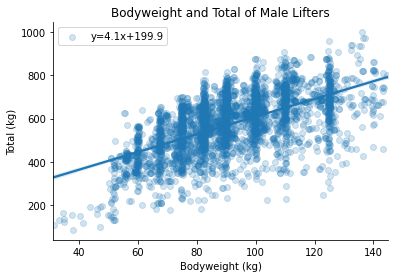

In [42]:
# Plotting bodyweight vs total of male lifters
slope_m, intercept_m, r_value_m, pv_m, se_m = stats.linregress(ok.loc[ok.Sex=='M', 'BodyweightKg'], ok.loc[ok.Sex=='M', 'TotalKg'])

sns.regplot(y='TotalKg', x='BodyweightKg', data=ok[ok.Sex == 'M'], x_jitter=.5, scatter_kws={'alpha':.2}, label='y={0:.1f}x+{1:.1f}'.format(slope_m, intercept_m)).legend(loc='best')
label_and_despine('Bodyweight and Total of Male Lifters', 'Bodyweight (kg)', 'Total (kg)')
plt.show()

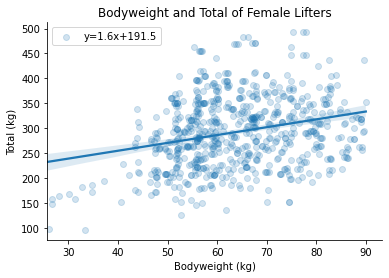

In [43]:
# Plotting bodyweight vs total of female lifters
slope_f, intercept_f, r_value_f, pv_f, se_f = stats.linregress(ok.loc[ok.Sex=='F', 'BodyweightKg'], ok.loc[ok.Sex=='F', 'TotalKg'])

sns.regplot(y='TotalKg', x='BodyweightKg', data=ok[ok.Sex == 'F'], x_jitter=.5, scatter_kws={'alpha':.2}, label='y={0:.1f}x+{1:.1f}'.format(slope_f, intercept_f)).legend(loc='best')
label_and_despine('Bodyweight and Total of Female Lifters', 'Bodyweight (kg)', 'Total (kg)')
plt.show()

## The number of competitor results by year

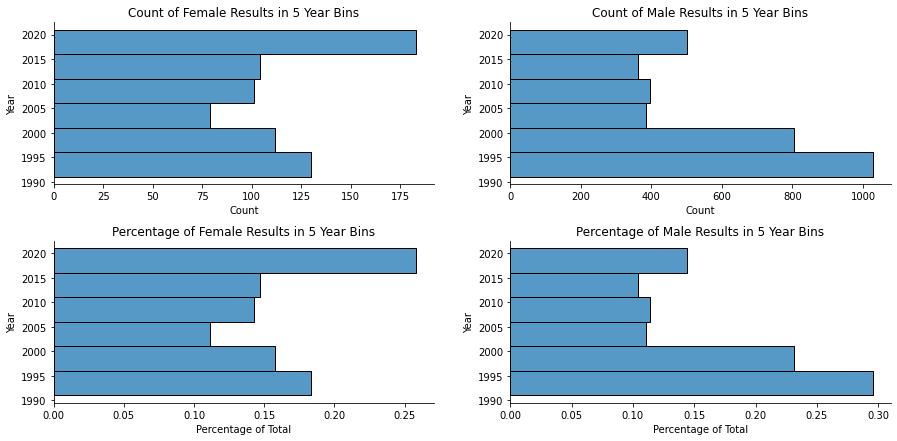

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7))
plt.subplots_adjust(hspace = 0.35)

axes[0,0].set_title('Count of Female Results in 5 Year Bins')
axes[0,0].set_ylabel('Year')
sns.histplot(ax=axes[0,0], y='MeetYear', data=ok[ok['Sex']=='F'], binwidth=5)

axes[0,1].set_title('Count of Male Results in 5 Year Bins')
axes[0,1].set_ylabel('Year')
sns.histplot(ax=axes[0,1], y='MeetYear', data=ok[ok['Sex']=='M'], binwidth=5)

axes[1,0].set_title('Percentage of Female Results in 5 Year Bins')
axes[1,0].set_xlabel('Percentage of Total')
axes[1,0].set_ylabel('Year')
sns.histplot(ax=axes[1,0], y='MeetYear', data=ok[ok['Sex']=='F'], binwidth=5, stat='probability')

axes[1,1].set_title('Percentage of Male Results in 5 Year Bins')
axes[1,1].set_xlabel('Percentage of Total')
axes[1,1].set_ylabel('Year')
sns.histplot(ax=axes[1,1], y='MeetYear', data=ok[ok['Sex']=='M'], binwidth=5, stat='probability')

sns.despine()
plt.show()

## How powerlifting scores have increased over the years

<AxesSubplot:xlabel='MeetYear', ylabel='TotalKg'>

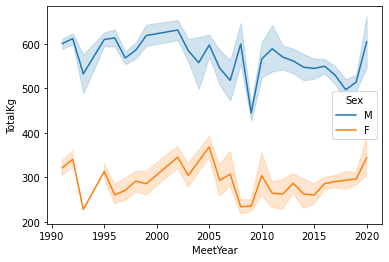

In [48]:
sns.lineplot(data=ok[['MeetYear', 'Sex', 'TotalKg']], x='MeetYear', y='TotalKg', hue='Sex')

# What Now?

This was a fun, informative project for me to hone my data science skills on a topic I'm hugely interested in. However, there are always ways to go deeper and do more with any dataset. Here are a few ideas, that I may end up coming back to.

* I was able to learn about some amazing feats of strength that have been performed right here in my own backyard. How does that compare to other states across the country? Where have the strongest competitors performed?

* Why keep my search confined to the US? Where have the greatest powerlifting performances taken place, globally?

* Does missing an entire lift (and bombing out) increase the probability that a lifter stops competing?

# Additional Resources

* [How do Powerlifting Meets Work?](https://powerliftingtechnique.com/how-do-powerlifting-meets-work/): A simple explanation of powerlifting meets from Avi Silverberg, an elite powerlifter competitor and coach

* [How is Powerlifting Scored?](https://powerliftingtechnique.com/how-is-powerlifting-scored/): A simple explanation of powerlifting is scored from Avi Silverberg, an elite powerlifter competitor and coach

* [What is a Good Wilks Score?](https://wilkscalculator.com/a/what-is-a-good-wilks-score): Another good explanation of powerlifting scoring, how Wilks in particular works, and some context around actual scores

* [The Greatest Wilks Scores of All Time](https://barbend.com/best-wilks-scores/): An infographic of some of the best performances ever recorded